# RihkyeTaskBatch dataset & LSTM_MD model

In [16]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('..')
from temp_model import MD, LSTM_MD
from temp_task import RikhyeTaskBatch

## Dataset

In [17]:
num_cueingcontext = 2
num_cue = 2
num_rule = 2
rule = [0, 1, 0, 1]
blocklen = [500, 500, 200]
block_cueingcontext = [0, 1, 0]
tsteps = 200
cuesteps = 100
batch_size = 1 # always set to 1 right now

dataset = RikhyeTaskBatch(num_cueingcontext=num_cueingcontext, num_cue=num_cue, num_rule=num_rule, rule=rule, blocklen=blocklen, \
block_cueingcontext=block_cueingcontext, tsteps=tsteps, cuesteps=cuesteps, batch_size=batch_size)

## Model

In [18]:
# Model settings
input_size = 4 # 4 cues
hidden_size = 200
output_size = 2 # 2 rules
num_layers = 1
Num_MD = 10
num_active = 5
tsteps = 200

model = LSTM_MD(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, Num_MD=Num_MD, \
    num_active=num_active, tsteps=tsteps)

#### Print model paramters

In [19]:
print(model)
for param in model.named_parameters():
    print(param[0], param[1].shape)

LSTM_MD(
  (lstm): LSTM(4, 200)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)
lstm.weight_ih_l0 torch.Size([800, 4])
lstm.weight_hh_l0 torch.Size([800, 200])
lstm.bias_ih_l0 torch.Size([800])
lstm.bias_hh_l0 torch.Size([800])
fc.weight torch.Size([2, 200])
fc.bias torch.Size([2])


## Training

In [20]:
import time

criterion = nn.MSELoss()
training_params = list()
for name, param in model.named_parameters():
    if 'lstm' not in name:
    # if True:
        print(name)
        training_params.append(param)
print('\n')
optimizer = torch.optim.Adam(training_params, lr=1e-3)


total_step = sum(blocklen)//batch_size
print_step = 10
running_loss = 0.0
running_train_time = 0
losses = []
timestamps = []
model_name = 'model-' + str(int(time.time()))
savemodel = False


for i in range(total_step):

    train_time_start = time.time()

    # extract data
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels).type(torch.float)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs, labels)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # normalization
    optimizer.step()

    # print statistics
    running_train_time += time.time() - train_time_start
    running_loss += loss.item()

    if i % print_step == (print_step - 1):

        print('Total step: {:d}'.format(total_step))
        print('Training sample index: {:d}-{:d}'.format(i+1-print_step, i+1))

        # running loss
        print('loss: {:0.5f}'.format(running_loss / print_step))
        losses.append(running_loss / print_step)
        timestamps.append(i+1-print_step)
        running_loss = 0.0

        # training time
        print('Predicted left training time: {:0.0f} s'.format(
        (running_train_time) * (total_step - i - 1) / print_step),
        end='\n\n')
        running_train_time = 0

        if savemodel:
            # save model every print_step
            fname = os.path.join('models', model_name + '.pt')
            torch.save(model.state_dict(), fname)

            # save info of the model
            fpath = os.path.join('models', model_name + '.txt')
            with open(fpath, 'w') as f:
                f.write('input_size = ' + str(input_size) + '\n')
                f.write('hidden_size = ' + str(hidden_size) + '\n')
                f.write('output_size = ' + str(output_size) + '\n')
                f.write('num_layers = ' + str(num_layers) + '\n')


print('Finished Training')

fc.weight
fc.bias


Total step: 1200
Training sample index: 0-10
loss: 0.46716
Predicted left training time: 300 s

Total step: 1200
Training sample index: 10-20
loss: 0.41809
Predicted left training time: 277 s

Total step: 1200
Training sample index: 20-30
loss: 0.37562
Predicted left training time: 311 s

Total step: 1200
Training sample index: 30-40
loss: 0.33944
Predicted left training time: 272 s

Total step: 1200
Training sample index: 40-50
loss: 0.30920
Predicted left training time: 257 s

Total step: 1200
Training sample index: 50-60
loss: 0.28424
Predicted left training time: 252 s

Total step: 1200
Training sample index: 60-70
loss: 0.26371
Predicted left training time: 274 s

Total step: 1200
Training sample index: 70-80
loss: 0.24681
Predicted left training time: 294 s

Total step: 1200
Training sample index: 80-90
loss: 0.23284
Predicted left training time: 300 s

Total step: 1200
Training sample index: 90-100
loss: 0.22115
Predicted left training time: 287 s

Total step

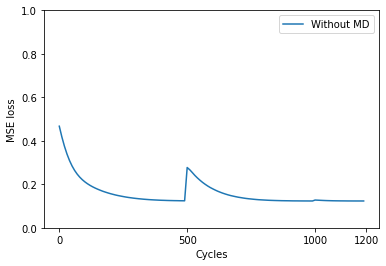

In [21]:
import matplotlib.pyplot as plt

plt.plot(timestamps, losses, label='Without MD')
plt.xlabel('Cycles')
plt.ylabel('MSE loss')
plt.legend()
plt.xticks([0, 500, 1000, 1200])
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

In [22]:
# deprecated
#lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=1, proj_size=2) # proj_size is not that useful here
lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=1)
input = torch.randn(5, 3, 10)
#h0 = torch.randn(1, 3, 20)
#c0 = torch.randn(1, 3, 20)
output, _= lstm(input)

print(output.shape)

torch.Size([5, 3, 20])
